<h1>Process Data</h1>
<h4>Haley Johnson</h4>

<p>Notebook to extract, combine and transform data</p>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os 

In [2]:
sns.set_style("darkgrid")
sns.color_palette("husl", 9)
sns.set_context("poster")
sns.set(font_scale = 1)

<h2>Manipulate Happiness Data</h2>

In [3]:
html = pd.read_html("happiest_cities.html")

In [4]:
happiness_df = html[0]

In [5]:
happiness_df = happiness_df.rename(columns = {'City': 'Location', 'Total Score': 'total_score', 
                                              'Emotional & Physical Well-Being':'emotional_physical_wellbeing', 
                                              'Income & Employment': 'income_employment', 
                                              'Community & Environment': 'community_environment'})

happiness_df['state'] = happiness_df['Location'].apply(lambda s: s.split(",")[-1])
happiness_df['city'] = happiness_df['Location'].apply(lambda s: s.split(",")[0])

happiness_df = happiness_df.drop(columns = ['Location'])

In [6]:
happiness_df['state'] = happiness_df['state'].str.strip().str.upper()
happiness_df['city'] = happiness_df['city'].str.strip().str.upper()

<h2>Manipulate Transportation Data</h2>

In [7]:
locations_df = pd.read_csv("EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv")

<h4>Remove Rows Where Location Is Missing</h4>

In [8]:
locations_df = locations_df[pd.isnull(locations_df['CBSA_Name']) == False]

In [9]:
for col in list(locations_df.columns):
    subset = locations_df[col]
    counts = pd.isnull(subset)
    counts = counts.value_counts()
    if True in counts.values:
        print(f"{col} contains missing values")

<h4>Setting Ranking Columns as Category</h4>

In [10]:
rankings = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for rank in rankings:
    locations_df[rank] = locations_df[rank].astype('category')

<h4>Get City and State Names</h4>

In [11]:
locations_df['CBSA_Name'] = locations_df['CBSA_Name'].astype(str)

In [12]:
locations_df['metro_area_cities'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[0])
locations_df['metro_area_states'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[-1])

locations_df['city'] = locations_df['metro_area_cities'].apply(lambda s: s.split("-"))
locations_df['state'] = locations_df['metro_area_states'].apply(lambda s: s.split("-"))

In [13]:
locations_df = locations_df.drop(columns = ['metro_area_cities', 'metro_area_states'])

<h3>Explode</h3>

In [14]:
exploded = locations_df.explode('city')
exploded = exploded.explode('state')
exploded = exploded.drop_duplicates()

In [15]:
exploded['city'] = exploded['city'].str.strip().str.upper()
exploded['state'] = exploded['state'].str.strip().str.upper()

<h2>Joining Happiness and Transportation Dataframes</h2>

<h4>Check that columns match</h4>

<p><b>St. Paul Minnestoa</b></p>

In [16]:
happiness_df[happiness_df['state'] == 'MN'][['city', 'state']]

,city,state
11,MINNEAPOLIS,MN
45,ST. PAUL,MN


In [17]:
exploded[exploded['state'] == 'MN'][['city', 'state']].sample(10)

,city,state
126702,BLOOMINGTON,MN
125567,BLOOMINGTON,MN
125673,ST. PAUL,MN
127451,ST. PAUL,MN
127012,MINNEAPOLIS,MN
129112,LA CROSSE,MN
128758,BLOOMINGTON,MN
127925,BLOOMINGTON,MN
126031,MINNEAPOLIS,MN
127301,ST. PAUL,MN


<p><b>New York City, NY</b></p>

In [18]:
happiness_df[happiness_df['state'] == 'NY'][['city', 'state']]

,city,state
43,YONKERS,NY
57,NEW YORK,NY
130,ROCHESTER,NY
135,BUFFALO,NY


In [19]:
exploded[exploded['state'] == 'NY'][['city', 'state']].sample(10)

,city,state
159398,SYRACUSE,NY
161851,NEWARK,NY
162834,JERSEY CITY,NY
159158,OGDENSBURG,NY
160624,ROCHESTER,NY
141420,JERSEY CITY,NY
141082,NEW YORK,NY
161688,NEW YORK,NY
160011,NEW YORK,NY
141719,NEWARK,NY


<p><b>Washington, D.C.</b></p>

In [20]:
happiness_df[happiness_df['state'] == 'DC'][['city', 'state']]

,city,state
84,WASHINGTON,DC


In [21]:
happiness_df[happiness_df['city'] == 'Arlington'][['city', 'state']]

,city,state


In [22]:
happiness_df[happiness_df['city'] == 'Alexandria'][['city', 'state']]

,city,state


In [23]:
exploded[exploded['state'] == 'DC'][['city', 'state']].sample(10)

,city,state
61633,ALEXANDRIA,DC
19004,ALEXANDRIA,DC
109644,ARLINGTON,DC
20855,ARLINGTON,DC
111723,ARLINGTON,DC
16206,ALEXANDRIA,DC
20521,ARLINGTON,DC
108060,ALEXANDRIA,DC
108070,ALEXANDRIA,DC
20489,ALEXANDRIA,DC


<h4>Joining</h4>

In [24]:
matches = exploded.merge(happiness_df, on = ['state', 'city'])

In [25]:
# NOTE TO SELF: When you add new columns up above, you need to adjust these 
vals = list(matches.columns)[11:-8] + list(happiness_df.columns)[:-2]
df = pd.pivot_table(matches, index = ['city', "state"], values = vals, aggfunc = 'mean')

In [26]:
df = df.reset_index()

<h4>Add in Regions</h4>

<p>Based on <a href="https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf">census designations</a></p>

In [27]:
regions = {}

regions['Pacific'] = ['CA', 'OR', 'WA', 'HI', 'AK']

regions['Mountain West'] = ['ID', 'NV', 'MT','WY', 'UT', 'CO', 'AZ', 'NM']

regions['West North Central'] = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO']

regions['West South Central'] = ['TX', 'OK', 'AR', 'LA']

regions['East North Central'] = ['WI', 'IL', 'MI', 'IN', 'OH']

regions['East South Central'] = ['KY', 'TN', 'MS', 'AL']

regions['South Atlantiic'] = ['FL', 'GA', 'SC', 'NC', 'VA', 'WV', 'DC', 'MD', 'DE']

regions['Middle Atlantic'] = ['PA', 'NY', 'NJ']

regions['New England'] = ['ME', 'VT', 'NH', 'MA', 'CT', 'RI']

regions['US Territories'] = ['PR']

In [28]:
def get_region(s):
    keys = list(regions.keys())
    for key in keys:
        if s in regions[key]:
            return key
    return None

In [29]:
df['Region'] = df['state'].apply(get_region)

<h2>Data Visualization</h2>

<h3>Example of Why Aggregation Is Helpful</h3>

Text(0.5, 0.98, 'Effect of Aggregating by City on Analysis')

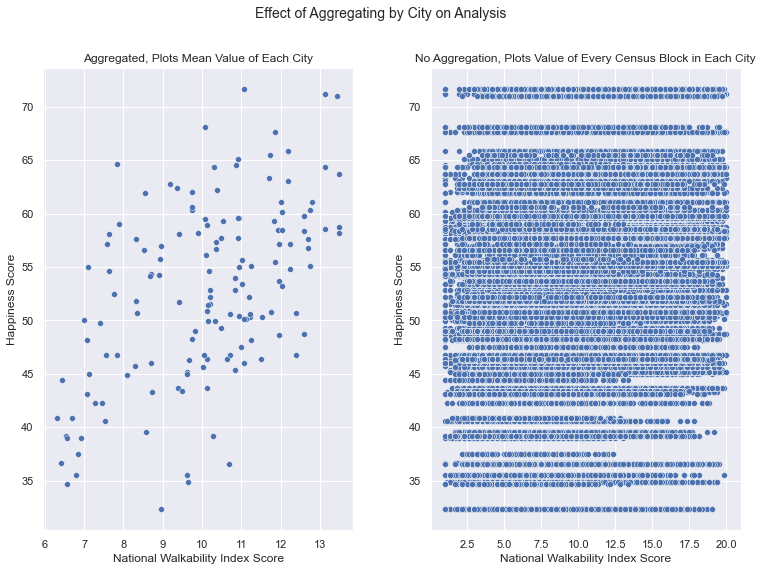

In [30]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12.5, 8.5)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

sns.scatterplot(x = 'NatWalkInd', y = 'total_score', data = df, ax = axes[0])
sns.scatterplot(x = 'NatWalkInd', y = 'total_score', data = matches, ax = axes[1])

# labels
axes[0].set_title('Aggregated, Plots Mean Value of Each City')
axes[0].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')
axes[1].set_title('No Aggregation, Plots Value of Every Census Block in Each City')
axes[1].set(ylabel = 'Happiness Score', xlabel = 'National Walkability Index Score')

# annotations
# axes[0].annotate('figure pixels', xy=(160, 55), xycoords='figure pixels')

fig.suptitle("Effect of Aggregating by City on Analysis", fontsize = 14)

<h3>Actual Visualization</h3>

Text(0.5, 1.0, 'Scatterplot of Walkability vs Happiness Scores')

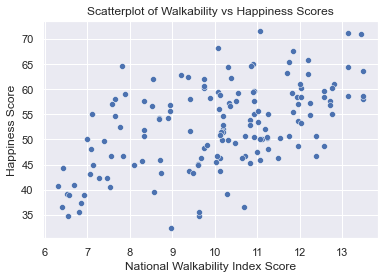

In [31]:
g = sns.scatterplot(x = 'NatWalkInd', y = 'total_score', data = df)
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.set_title("Scatterplot of Walkability vs Happiness Scores")

Text(0.5, 1.0, 'Scatterplot of Walkability vs Happiness Scores')

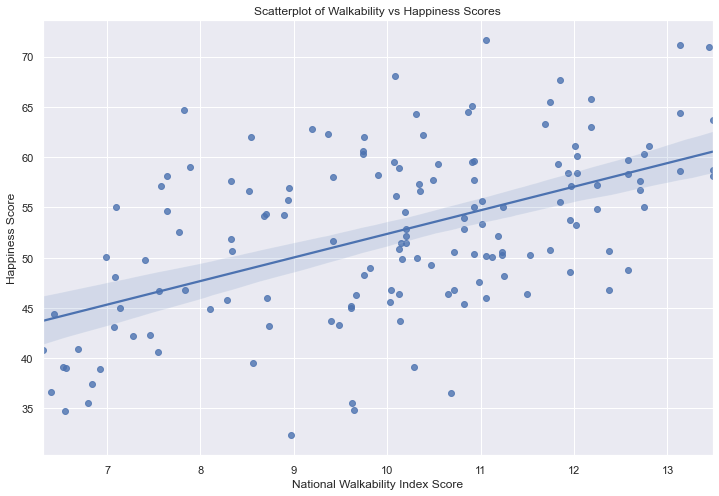

In [32]:
rcParams['figure.figsize'] = 12,8
g = sns.regplot(x = 'NatWalkInd', y = 'total_score', data = df)
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.set_title("Scatterplot of Walkability vs Happiness Scores")

Text(0.4, 1.05, 'Scatterplot of Walkability vs Happiness Scores')

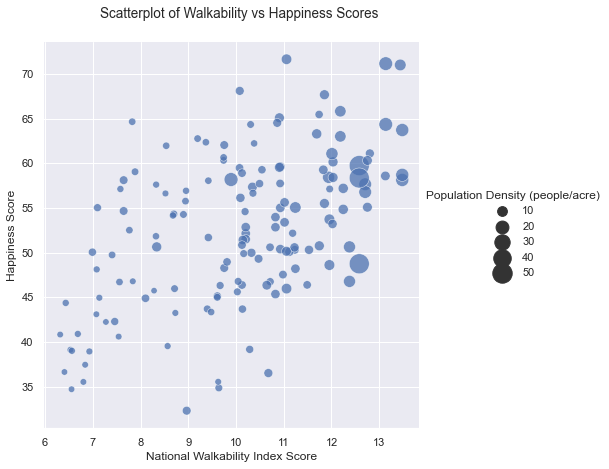

In [33]:
df = df.rename(columns = {'D1B' : 'Population Density (people/acre)'})

g = sns.relplot(x = "NatWalkInd", y = "total_score", size = "Population Density (people/acre)",
            sizes = (40, 400), alpha = 0.75, palette = "muted", 
            height = 6, data = df)

# plt.legend(loc = 'lower right', borderaxespad = 2, title = 'Population Density (people/acre)')

g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')
g.fig.suptitle("Scatterplot of Walkability vs Happiness Scores", y = 1.05, x = 0.4, fontsize = 13.5)


<h3>Variations by Region</h3>

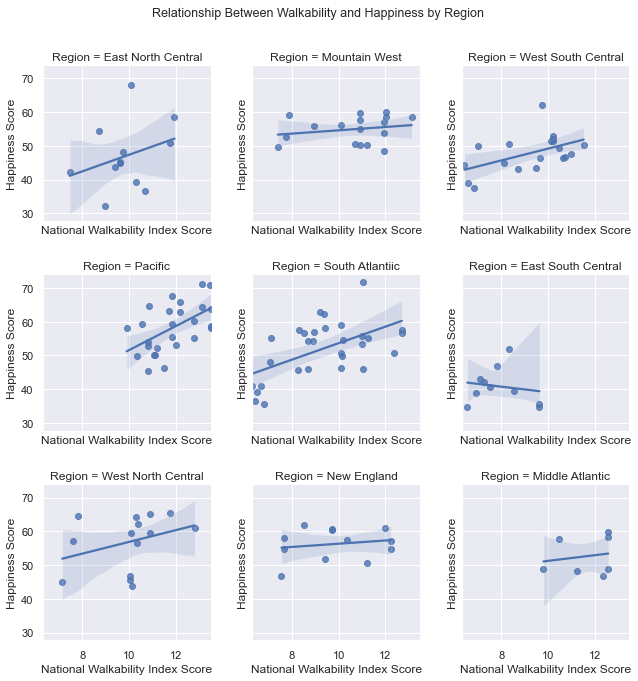

In [34]:
g = sns.FacetGrid(df, col = "Region", col_wrap = 3)
g.map(sns.regplot, "NatWalkInd", "total_score")
g.set(xlabel = 'National Walkability Index Score', ylabel = 'Happiness Score')

g.fig.suptitle("Relationship Between Walkability and Happiness by Region", y = 1.05, fontsize = 12.5)
g.fig.subplots_adjust(wspace = 0.25, hspace = 0.35)

In [35]:
by_region = df.groupby('Region')
happiness_by_region = by_region.describe()['total_score'].sort_values(by = 'mean', ascending = False)
happiness_by_region = happiness_by_region.rename(columns = {'mean': 'average_happiness_score'})

walkability_by_region = by_region.describe()['NatWalkInd'].sort_values(by = 'mean', ascending = False)
walkability_by_region = walkability_by_region.rename(columns = {'mean': 'average_walkability_score'})

happiness_by_region = happiness_by_region['average_happiness_score']
walkability_by_region = walkability_by_region['average_walkability_score']

regional_variations = pd.concat([happiness_by_region, walkability_by_region], axis = 1)

In [36]:
regional_variations

,average_happiness_score,average_walkability_score
Region,,
Pacific,58.197692,11.856247
West North Central,56.905000,10.016230
New England,56.260000,9.863358
Mountain West,54.908824,10.636201
Middle Atlantic,52.642857,11.668197
South Atlantiic,51.932667,9.306112
West South Central,47.870000,9.262742
East North Central,47.002500,9.851519
East South Central,40.815000,7.936037


<h4>Statistical Tests for Different in Mean Across Regions</h4>

In [37]:
# moore_lm = ols(' ~ C(fcategory, Sum)*C(partner_status, Sum)', data = df).fit()

In [38]:
happiness_df.head()

,Overall Rank,total_score,emotional_physical_wellbeing,income_employment,community_environment,state,city
0,1,77.13,1,46,2,CA,FREMONT
1,2,71.64,3,161,5,MD,COLUMBIA
2,3,71.15,4,1,44,CA,SAN FRANCISCO
3,4,71.00,2,6,55,CA,SAN JOSE
4,5,70.38,5,16,12,CA,IRVINE


<h3>Different Components of Happiness Scores</h3>

Text(0.5, 0.98, 'Walkability Index vs Happiness Score Components')

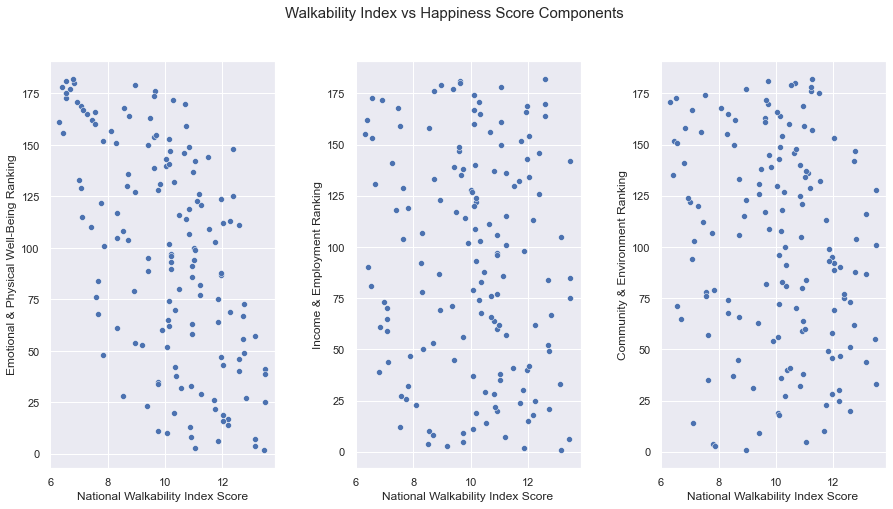

In [39]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15, 7.5)
fig.subplots_adjust(hspace = 0.5, wspace = 0.35)

axes[0] = sns.scatterplot(x = 'NatWalkInd', y = 'emotional_physical_wellbeing', data = df, ax = axes[0])
axes[1] = sns.scatterplot(x = 'NatWalkInd', y = 'income_employment', data = df, ax = axes[1])
axes[2] = sns.scatterplot(x = 'NatWalkInd', y = 'community_environment', data = df, ax = axes[2])


axes[0].set(xlabel = 'National Walkability Index Score', ylabel = 'Emotional & Physical Well-Being Ranking')
axes[1].set(xlabel = 'National Walkability Index Score', ylabel = 'Income & Employment Ranking')
axes[2].set(xlabel = 'National Walkability Index Score', ylabel = 'Community & Environment Ranking')

fig.suptitle("Walkability Index vs Happiness Score Components", fontsize = 15)

<h3>Average Happiness Score by 4 Walkability Index Ratings</h3>

Text(0.5, 0.98, 'Happiness Scores vs Walkability Index Ranking')

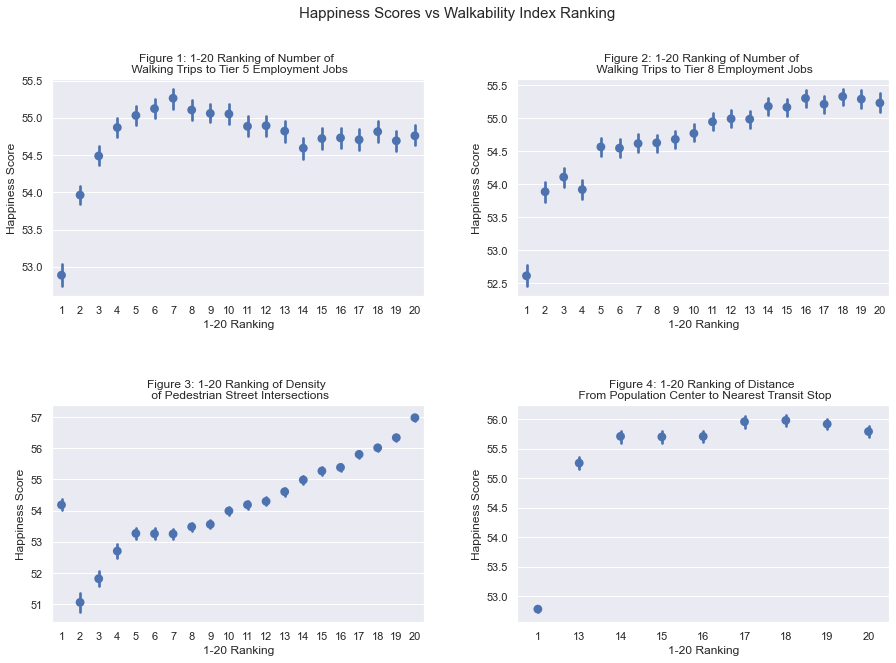

In [40]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(15, 10)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

targets = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for i, ax in enumerate(axes.flatten()):
    g = sns.pointplot(x = targets[i], y = 'total_score', data = matches, join = False, ax = ax)
    g.set_xticklabels(g.get_xticklabels())
    g.set_xlabel(xlabel = '1-20 Ranking')
    g.set_ylabel('Happiness Score')
    
# set titles
axes[0][0].set_title('Figure 1: 1-20 Ranking of Number of \n Walking Trips to Tier 5 Employment Jobs')
axes[0][1].set_title('Figure 2: 1-20 Ranking of Number of \n Walking Trips to Tier 8 Employment Jobs')
axes[1][0].set_title('Figure 3: 1-20 Ranking of Density \n of Pedestrian Street Intersections')
axes[1][1].set_title('Figure 4: 1-20 Ranking of Distance \n From Population Center to Nearest Transit Stop')

fig.suptitle("Happiness Scores vs Walkability Index Ranking", fontsize = 15)